# Import Necessary Libraries

In [ ]:
!pip install -q contractions
import pandas as pd
import numpy as np
import seaborn as sns
import contractions
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
import spacy
import nltk
import random
from tqdm import tqdm
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from itertools import cycle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW  # Import AdamW from torch.optim instead
nltk.download('wordnet') # Download the 'wordnet' dataset
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# **Exploratory Data Analysis**

First 5 rows of the dataset:
     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...

Shape of the dataset (rows, columns):
(40000, 3)

Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB
None

Number of missing values in each column:
tweet_id     0
sentiment 

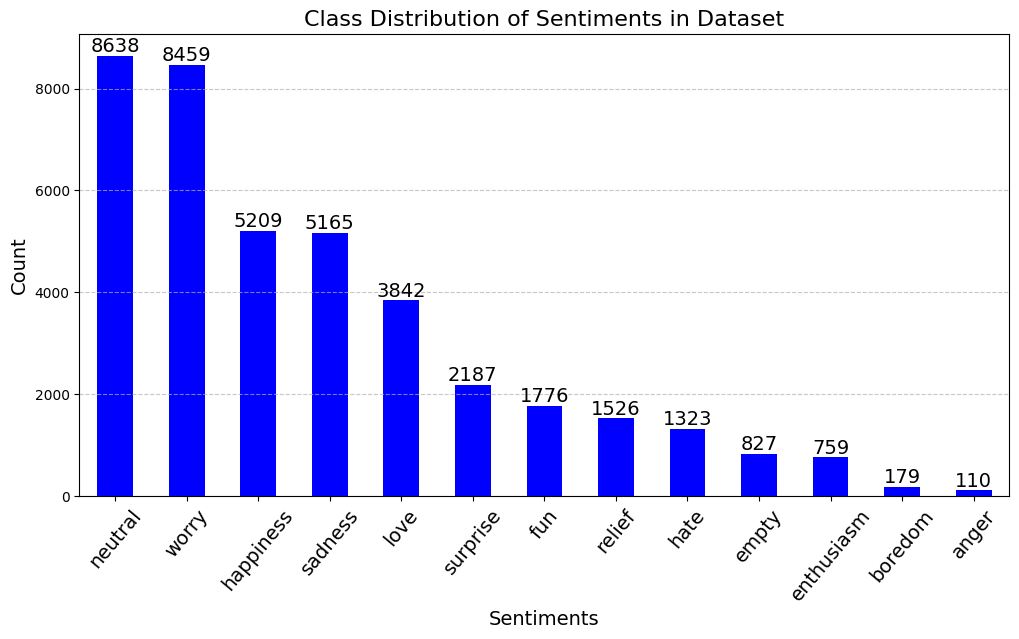

In [ ]:
# Read CSV
tweet_emotions = pd.read_csv('tweet_emotions.csv')
# Analyze data
print("First 5 rows of the dataset:")
print(tweet_emotions.head())  # Display the first few rows

print("\nShape of the dataset (rows, columns):")
print(tweet_emotions.shape)  # Display shape

print("\nInformation about the dataset:")
print(tweet_emotions.info())  # Display info

print("\nNumber of missing values in each column:")
print(tweet_emotions.isnull().sum())  # Display missing values

print("\nDuplicate valuess in dataset:")
print(tweet_emotions.duplicated().sum())  # Display duplicate number

# Count the occurrences of each sentiment
class_distribution = tweet_emotions['sentiment'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar', color='blue')
plt.title("Class Distribution of Sentiments in Dataset", fontsize=16)
plt.xlabel("Sentiments", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Increase font size for x-axis sentiment labels
plt.xticks(rotation=50, fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels in the plot
for i, count in enumerate(class_distribution):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=14)

plt.show()

# **Data Cleaning**

In [ ]:
stop_words = set(stopwords.words('english'))
#a dictionary for informal contractions
contraction_dict = {
    "im": "I am", "u": "you", "lol": "laughing out loud", "cant": "can not", "wont": "will not",
    "idk": "I do not know", "omg": "oh my god", "thx": "thanks", "pls": "please", "plz": "please",
    "btw": "by the way", "b4": "before", "ur": "your", "urself": "yourself", "amp": "and", "gud": "good",
    "sum1": "someone", "no1": "no one", "sum": "some", "cuz": "because", "ive": "I have", "hes": "he is",
    "shes": "she is", "thats": "that is", "theres": "there is", "youre": "you are", "youve": "you have",
    "youll": "you will", "lmao": "laughing my ass off", "smh": "shaking my head", "tbh": "to be honest",
    "tho": "though", "aint": "is not", "rly": "really", "rn": "right now", "yall": "you all", "gr8": "great",
    "l8r": "later", "brb": "be right back", "imma": "I am going to", "gg": "good game", "idc": "I do not care",
    "omw": "on my way", "ok": "okay", "enuff": "enough", "Cali": "California", "SoCal": "Southern California",
    "fridaayy": "friday", "-": " ", "I'd": "I would", "I've": "I have", "I'll": "I will", "I'm": "I am",
    "let's": "let us", "MIA": "missing in the air", "lol": "laughing out loud", "idk": "I do not know",
}
def expand_custom_contractions(tweet):
    for contraction, expanded in contraction_dict.items():
        text = re.sub(r'\b' + contraction + r'\b', expanded, tweet)
    return tweet

def clean_tweet(tweet):
    """
    Cleans a tweet by removing mentions, URLs, hashtags, special characters,
    and stopwords. Keeps the hashtag text but removes the '#' symbol.
    """
    # Expand all contractions using the contractions library
    tweet = contractions.fix(tweet)

    # Expand additional informal contractions
    tweet = expand_custom_contractions(tweet)
    # Remove mentions
    tweet = re.sub(r"@\w+", "", tweet)
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)
    # Remove special characters and numbers, but keep hashtag text
    tweet = re.sub(r"[^a-zA-Z#]", " ", tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove stopwords
    tweet = " ".join([word for word in tweet.split() if word not in stop_words])
    # Replace "in'" at the end of words with "ing" (e.g., "listenin'" -> "listening")
    tweet = re.sub(r"\b(\w*[bcdfghjklmnpqrtvwxz]in)\b", r"\1g", tweet)
    # Replace repeated punctuation for emphasis, but keep single instances
    tweet = re.sub(r'\.{2,}', ' ', tweet)  # Replace repeated dots with a single space
    tweet = re.sub(r'[!]{2,}', '!', tweet)  # Standardize multiple exclamation marks to one
    tweet = re.sub(r'[?]{2,}', '?', tweet)  # Standardize multiple question marks to one
    # Reduce any repeated characters (e.g., "ughhh" -> "ugh")
    tweet = re.sub(r'(.)\1{2,}', r'\1', tweet)  # Replace 3+ repeated characters with two characters

    return tweet

# Apply the cleaning function to the 'content' column
tweet_emotions['cleaned_content'] = tweet_emotions['content'].apply(clean_tweet)

# Display a sample of the cleaned tweets
tweet_emotions[['content', 'cleaned_content']].head()

,content,cleaned_content
0,@tiffanylue i know i was listenin to bad habi...,know listening bad habit earlier started freak...
1,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ugh waiting call
2,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,wants to hang out with friends SOON!,wants hang friends soon
4,@dannycastillo We want to trade with someone w...,want trade someone houston tickets one


Label Mapping: {'anger': np.int64(0), 'boredom': np.int64(1), 'empty': np.int64(2), 'enthusiasm': np.int64(3), 'fun': np.int64(4), 'happiness': np.int64(5), 'hate': np.int64(6), 'love': np.int64(7), 'neutral': np.int64(8), 'relief': np.int64(9), 'sadness': np.int64(10), 'surprise': np.int64(11), 'worry': np.int64(12)}


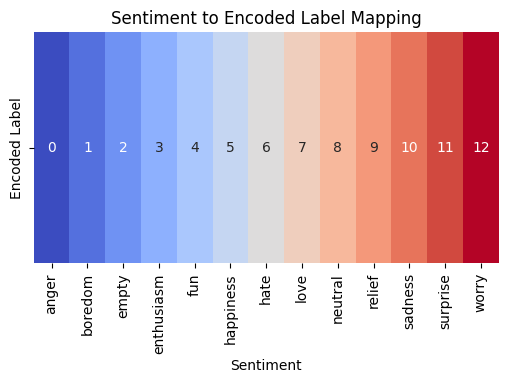

In [ ]:
# Encode the sentiment column
label_encoder = LabelEncoder()
tweet_emotions['label'] = label_encoder.fit_transform(tweet_emotions['sentiment'])
tweet_emotions[['sentiment', 'label']].head()

# Save label mapping for later use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Convert the label mapping dictionary to a DataFrame
label_mapping_df = pd.DataFrame(list(label_mapping.items()), columns=['Sentiment', 'Encoded Label'])

# Create a heatmap to display the mapping
plt.figure(figsize=(6, 3))
sns.heatmap(label_mapping_df.set_index('Sentiment').T, annot=True, cmap="coolwarm", cbar=False)
plt.title("Sentiment to Encoded Label Mapping")
plt.xlabel("Sentiment")
plt.ylabel("")
plt.show()

# **Approach 1**

In [ ]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define a more comprehensive irrelevant word list based on emotional neutrality
irrelevant_words_by_sentiment = {
"anger": ["studying","cooperating","german","english","usual","accomplish","waking","manageable","nice", "breeding", "oven","packing",'blond',"chunk", "middle", "traveling", "wendys", "happening","going", "get", "got", "go", "got", "know", "want","feel" ,"think","want","good", "sorry", "big", "front", "brown", "serious", "red", "fucking",
          "left", "right", "old", "eating", "sleepy", "great", "full", "finding", "high", "free", "numb", "better", "jeuno"],
"boredom": ["next","open","taking", "moving", "quick","talking", "tweeting", "happy","bad", "cleaning", "feeling", "last", "getting","going", "get", "got", "go", "got", "know", "want","feel" ,"think","want", "good", "great", "much", "new"],
"empty": ["boring","getting", "great","happy", "making","going", "get", "got", "go", "got", "know", "want","feel" ,"think","want","good", "new", "bored", "last", "tired", "much", "nice", "bad", "ready"],
"enthusiasm": [ "jealous", "moving", "following","tired", "better", "lazy","trying","bad", "long", "stupid", "hot", "sick","taking","right", "waiting",  "watching", "early","sexy", "little", "much","looking", "next", "nice", "working", "getting", "live", "making", "going", "get", "got", "go", "got", "know", "want","feel" ,"think","want","good", "new", "great", "last", "ready", "first", "best"],
"fun": ["little", "working", "big", "first", "looking", "trying","long", "bad", "old", "right", "coming", "ready","going", "get", "got", "go", "got", "know", "want","feel" ,"think","want","good", "great", "new", "last", "nice", "much", "amazing", "getting", "watching", "cool", "playing", "lol", "next"],
"happiness": ["little", "next","watching", "getting","going", "get", "got", "go", "got", "know", "want","feel" ,"think","want","good", "new", "last", "much", "sick"],
"hate": ["whole","making","trying","long","talking","right","fucking", "getting", "working", "next", "going", "get", "got", "go", "got", "know", "want","feel" ,"think","want","good", "new", "much", "last"],
"love": ["last", "watching", "going", "get", "got", "go", "got", "know", "want","feel" ,"think","want","good", "new", "much", "awesome"],
"neutral": ["happy","nice","bad","going", "get", "got", "go", "got", "know", "want","feel" ,"think","want","good", "new", "last", "next", "ready", "right"],
"relief": ["tired","getting", "long","watching","ready","going", "get", "got", "go", "got", "know", "want","feel" ,"think","want","good", "new", "last", "much", "bad"],
"sadness": ["best","looking","trying","great","little","watching","happy","nice","stupid","getting","working","feeling","next","going", "get", "got", "go", "got", "know", "want","feel" ,"think","want","good", "bad", "new", "much"],
"surprise": ["looking","hot","better", "cute","trying","working","right","old","watching","coming","happy","getting","going", "get", "got", "go", "got", "know", "want","feel" ,"think","want","good", "new", "last", "next", "nice", "sorry"],
"worry": ["watching","hot","sure","first","big", "right", "ready", "coming","working","nice","long","looking","new","getting","feeling","trying","tired","going", "get", "got", "go", "got", "know", "want","feel" ,"think","want", "good", "last", "much", "next", "happy", "little", "great", "better"]
}

# Function to extract adjecwordstives specific to each sentiment
def get_top_words(df, sentiment_col, text_col, top_n=10):
    sentiment_groups = df.groupby(sentiment_col)
    top_words = {}

    for sentiment, group in sentiment_groups:
        # Tokenize the text and extract words
        words = " ".join(group[text_col]).split()
        doc = nlp(" ".join(words))

        # Filter adjectives, verb, interjection and exclude irrelevant words
        words = [token.text.lower() for token in doc  if (token.pos_ == "ADJ" or (token.pos_ == "VERB" and token.text.endswith("ing"))) and token.text.lower() not in irrelevant_words_by_sentiment.get(sentiment, [])]

        # Count the words
        words_counts = Counter(words)
        top_words[sentiment] = words_counts.most_common(top_n)

    return top_words

# Extract top adjectives for each sentiment
top_words_by_sentiment = get_top_words(tweet_emotions, 'sentiment', 'cleaned_content', top_n=10)

# Format top words for each sentiment as "sentiment: word(count), word(count), ..."
def format_top_words_for_display(top_words_dict):
    formatted_output = {}
    for sentiment, words in top_words_dict.items():
        formatted_output[sentiment] = ", ".join([f"{word}({count})" for word, count in words])
    return formatted_output

# Get formatted output
top_words = format_top_words_for_display(top_words_by_sentiment)

# Display formatted output
for sentiment, words in top_words.items():
    print(f"{sentiment}: {words}")


anger: bad(3), stupid(2), annoying(2), sick(2), sitting(2), filthy(2), working(1), hard(1), windy(1), horrible(1)
boredom: bored(23), tired(11), boring(8), sitting(7), waiting(4), stuck(3), slow(2), old(2), amp(2), working(2)
empty: looking(12), free(10), watching(9), trying(9), working(8), sitting(6), enough(6), little(6), hot(6), long(5)
enthusiasm: awesome(11), happy(10), cool(9), bored(8), final(6), ok(5), interesting(5), free(5), leaving(4), excited(4)
fun: funny(38), happy(24), awesome(22), fun(19), best(18), tired(15), hot(14), better(14), listening(13), crazy(13)
happiness: happy(391), great(279), nice(146), awesome(113), amazing(92), best(82), glad(72), ready(60), cool(58), looking(53)
hate: stupid(42), bad(40), sick(26), tired(19), cold(16), hot(12), horrible(11), bored(10), damn(10), annoying(9)
love: happy(556), great(141), amazing(86), nice(85), best(84), lovely(62), sweet(60), cute(54), beautiful(50), loving(47)
neutral: watching(139), getting(94), great(86), working(79),

In [ ]:
# Synonym Replacement Function
def synonym_replacement(text, top_words, replacement_prob=0.3):
    """
    Replace words in the text with synonyms based on the top_words list and replacement probability.
    """
    words = text.split()
    augmented_text = []
    for word in words:
        if word in top_words and random.random() < replacement_prob:
            synonyms = wordnet.synsets(word)
            if synonyms:
                synonym = synonyms[0].lemmas()[0].name()  # Get the first synonym
                if synonym != word:  # Ensure synonym is different
                    word = synonym
        augmented_text.append(word)
    return " ".join(augmented_text)

# Augment Underrepresented Classes with Synonym Replacement
def augment_with_synonyms_and_reduce_repetition(df, sentiment_col, text_col, top_words_dict, replacement_prob=0.3, target_count=3000):
    """
    Augment underrepresented classes with synonym replacement, reduce repetitions, and limit each class to 3,000 samples.
    """
    augmented_data = []
    for sentiment, group in df.groupby(sentiment_col):
        if len(group) >= target_count:
            # Keep classes with >= target_count unchanged
            augmented_data.append(group.sample(target_count, random_state=42))
        else:
            # Augment only classes with < target_count
            needed_samples = target_count - len(group)
            original_texts = group[text_col].tolist()
            augmented_samples = []
            text_pool = cycle(original_texts)  # Cycle through original texts for variety
            while len(augmented_samples) < needed_samples:
                text = next(text_pool)  # Get the next text from the pool
                top_words = [word for word, _ in top_words_dict.get(sentiment, [])]
                augmented_text = synonym_replacement(text, top_words, replacement_prob)
                # Avoid adding exact duplicates
                if augmented_text not in augmented_samples:
                    augmented_samples.append((augmented_text, sentiment))
            # Combine original and augmented samples
            augmented_group = pd.DataFrame(augmented_samples, columns=[text_col, sentiment_col])
            augmented_data.append(pd.concat([group, augmented_group], ignore_index=True))
    return pd.concat(augmented_data, ignore_index=True)

# Identify underrepresented classes
class_distribution = tweet_emotions['sentiment'].value_counts()
underrepresented_classes = class_distribution[class_distribution < 3000].index.tolist()
print(f"Underrepresented classes (fewer than 3000 samples): {underrepresented_classes}")

# Filter data for underrepresented classes
underrepresented_data = tweet_emotions[tweet_emotions['sentiment'].isin(underrepresented_classes)]

# Augment only underrepresented classes
augmented_tweets_synonyms_limited = augment_with_synonyms_and_reduce_repetition(
    underrepresented_data,  # Pass only underrepresented classes
    sentiment_col='sentiment',
    text_col='cleaned_content',
    top_words_dict=top_words_by_sentiment,
    replacement_prob=0.3,
    target_count=3000
)

# Combine with classes already having >=3000 samples
overrepresented_data = tweet_emotions[~tweet_emotions['sentiment'].isin(underrepresented_classes)]
final_augmented_dataset = pd.concat([overrepresented_data, augmented_tweets_synonyms_limited], ignore_index=True)

#add labels to new added ones
final_augmented_dataset['label'] = label_encoder.transform(final_augmented_dataset['sentiment'])

# Display final class distribution
print("Final Class Distribution (Limited to 3,000 per class):")
print(final_augmented_dataset['sentiment'].value_counts())


Underrepresented classes (fewer than 3000 samples): ['surprise', 'fun', 'relief', 'hate', 'empty', 'enthusiasm', 'boredom', 'anger']
Final Class Distribution (Limited to 3,000 per class):
sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
anger         3000
boredom       3000
empty         3000
enthusiasm    3000
fun           3000
hate          3000
relief        3000
surprise      3000
Name: count, dtype: int64


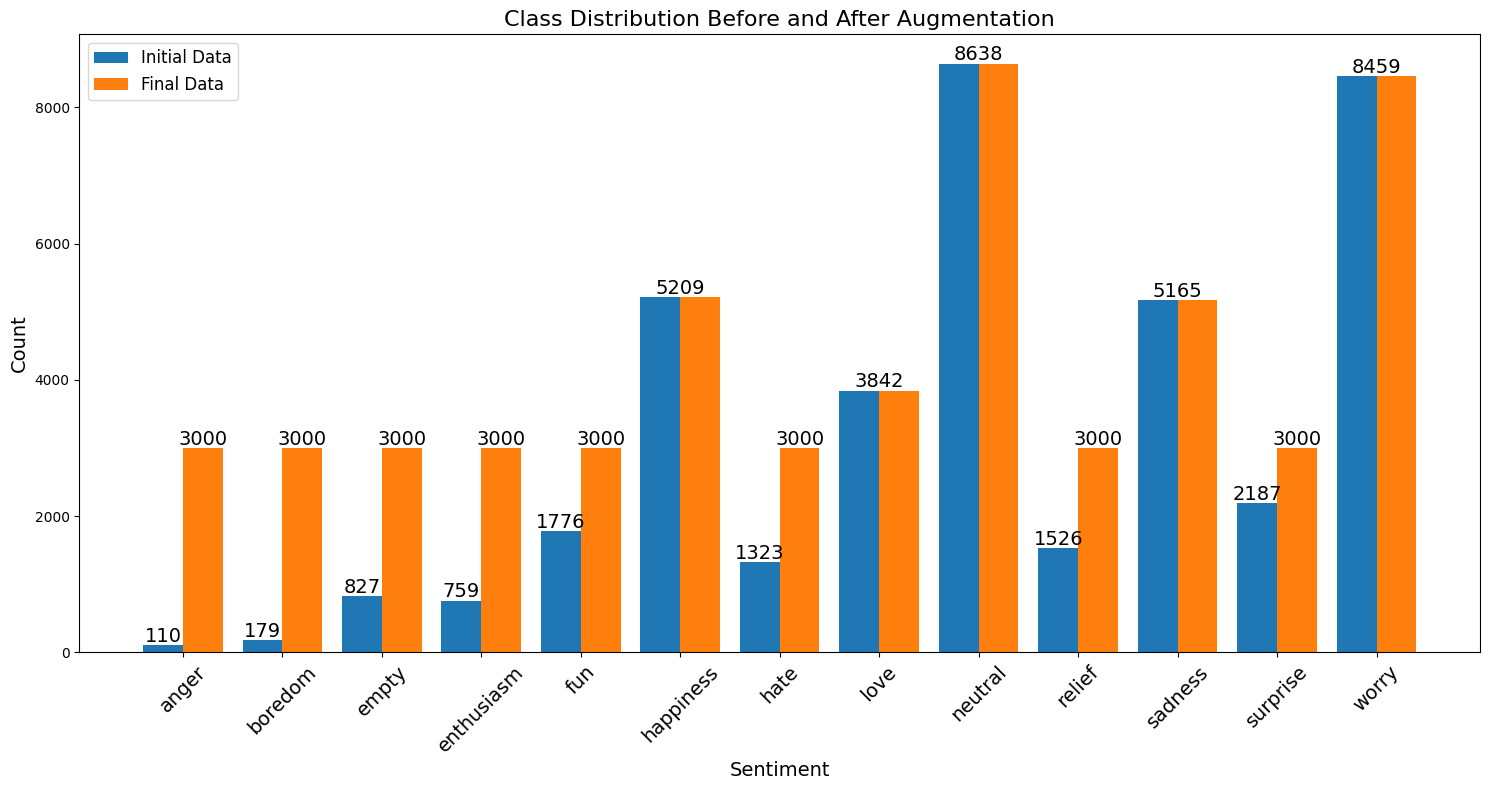

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate class distributions
initial_counts = tweet_emotions['sentiment'].value_counts().sort_index()
final_counts = final_augmented_dataset['sentiment'].value_counts().sort_index()

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Sentiment': initial_counts.index,
    'Initial': initial_counts.values,
    'Final': final_counts.values
})

# Plot side-by-side bar chart with a gap between the bars
x = np.arange(len(comparison_df))  # Label locations
width = 0.4  # Reduced the width to create a gap between bars

fig, ax = plt.subplots(figsize=(15, 8))
bars1 = ax.bar(x - width/2, comparison_df['Initial'], width, label='Initial Data')
bars2 = ax.bar(x + width/2, comparison_df['Final'], width, label='Final Data')

# Add labels, title, and legend
ax.set_xlabel('Sentiment', fontsize=14)  # Larger font size
ax.set_ylabel('Count', fontsize=14)  # Larger font size
ax.set_title('Class Distribution Before and After Augmentation', fontsize=16)  # Larger font size
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Sentiment'], rotation=45, fontsize=14)  # Larger font size
ax.legend(fontsize=12)

# Loop over the bars to add data labels
for bar1, bar2 in zip(bars1, bars2):
    yval1 = bar1.get_height()
    yval2 = bar2.get_height()

    # If both bars have the same value, add one label in the middle of both bars
    if yval1 == yval2:
        x_pos = (bar1.get_x() + bar1.get_width()/2 + bar2.get_x() + bar2.get_width()/2) / 2
        ax.text(x_pos, max(yval1, yval2) + 50, f'{int(yval1)}', ha='center', fontsize=14, color='black')
    else:
        # Add data label for bar1 (Initial) at the top of bar1
        ax.text(bar1.get_x() + bar1.get_width()/2, yval1 + 50, int(yval1), ha='center', fontsize=14, color='black')

        # Add data label for bar2 (Final) at the top of bar2
        ax.text(bar2.get_x() + bar2.get_width()/2, yval2 + 50, int(yval2), ha='center', fontsize=14, color='black')

plt.tight_layout()
plt.show()


# **Approach-2**

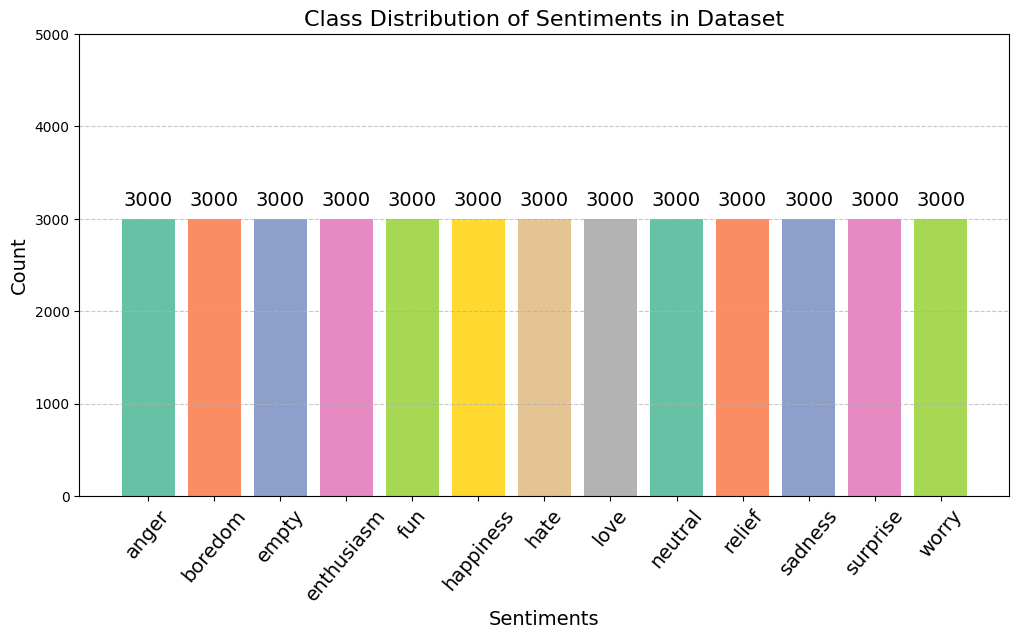

In [ ]:
# Load synthesized data
synthesized_data = pd.read_csv("SynthesisedTweets.csv", encoding='latin-1')

# Combine original and synthesized data
combined_data = pd.concat([tweet_emotions, synthesized_data], ignore_index=True)

# Balance the dataset
def balance_dataset(df, sentiment_col, target_count=3000):
    balanced_data = []
    for sentiment, group in df.groupby(sentiment_col):
        if len(group) > target_count:
            # Sample if the class has more than the target_count
            balanced_data.append(group.sample(target_count, random_state=42))
        else:
            # Oversample if the class has less than the target_count
            balanced_data.append(group.sample(target_count, replace=True, random_state=42))
    return pd.concat(balanced_data, ignore_index=True)

balanced_data = balance_dataset(combined_data, sentiment_col='sentiment', target_count=3000)

# Apply the cleaning function to the 'content' column
balanced_data['content'] = balanced_data['content'].apply(clean_tweet)

#add label
balanced_data['label'] = label_encoder.transform(balanced_data['sentiment'])

class_distribution = balanced_data['sentiment'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(12, 6))

# Get the class distribution
class_distribution = balanced_data['sentiment'].value_counts()

# Use a Seaborn color palette (you can choose any palette you like)
colors = sns.color_palette("Set2", len(class_distribution))  # Set2 provides distinct colors

# Plot bars with distinct colors
bars = plt.bar(class_distribution.index, class_distribution.values, color=colors)

# Title and labels
plt.title("Class Distribution of Sentiments in Dataset", fontsize=16)
plt.xlabel("Sentiments", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Increase font size for x-axis sentiment labels
plt.xticks(rotation=50, fontsize=14)

# Set y-axis limit to 5000
plt.ylim(0, 5000)

# Gridlines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100, str(int(height)), ha='center', va='bottom', fontsize=14, color='black')

plt.show()

# **Approach-3**

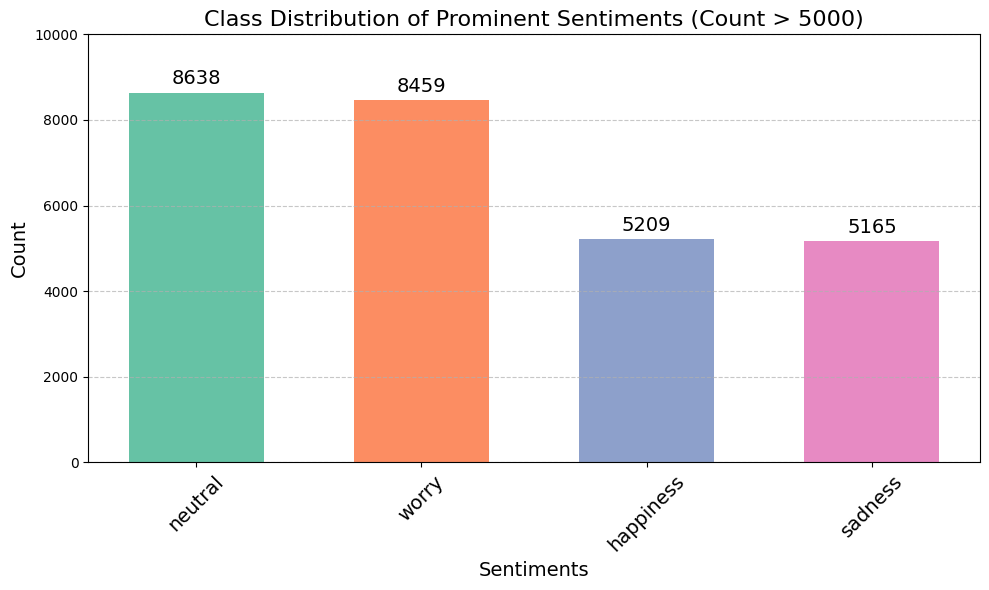

In [ ]:
# Filter prominent classes
prominent_classes = tweet_emotions['sentiment'].value_counts()
prominent_classes = prominent_classes[prominent_classes > 5000].index

# Create a filtered dataset using .loc
filtered_data = tweet_emotions[tweet_emotions['sentiment'].isin(prominent_classes)].copy()

# Apply the cleaning function to the 'content' column
filtered_data.loc[:, 'content'] = filtered_data['content'].apply(clean_tweet)

# Add label column after encoding
filtered_data.loc[:, 'label'] = label_encoder.transform(filtered_data['sentiment'])

# Plot the class distribution for the filtered dataset
plt.figure(figsize=(10, 6))

# Get the class distribution of the filtered data
filtered_class_distribution = filtered_data['sentiment'].value_counts()

# Use a Seaborn color palette for distinct bar colors
colors = sns.color_palette("Set2", len(filtered_class_distribution))

# Adjust bar width (make bars thinner by reducing the width parameter)
bar_width = 0.6  # Decrease this value to make bars thinner

# Plot bars with distinct colors
bars = plt.bar(filtered_class_distribution.index, filtered_class_distribution.values, color=colors, width=bar_width)

# Add title and labels
plt.title("Class Distribution of Prominent Sentiments (Count > 5000)", fontsize=16)
plt.xlabel("Sentiments", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Set y-axis limit to 10,000
plt.ylim(0, 10000)

# Increase font size for x-axis sentiment labels
plt.xticks(rotation=45, fontsize=14)

# Gridlines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100, str(int(height)),
             ha='center', va='bottom', fontsize=14, color='black')

plt.tight_layout()
plt.show()

# **Shared Functions in 3 Approaches**

In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def calculate_max_length(data, text_column, tokenizer):
    """
    Calculate the maximum tokenized sequence length in the dataset.
    """
    max_length = max(
        len(tokenizer.encode(text, add_special_tokens=True))
        for text in data[text_column]
    )
    return min(max_length, tokenizer.model_max_length)  # Ensure it doesn't exceed BERT's max length


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_data(dataset, text_column, label_column, tokenizer, max_length, label_mapping):
    """
    Tokenizes the dataset for BERT input.

    Parameters:
    - dataset: Pandas DataFrame containing the dataset.
    - text_column: Column name for the text data.
    - label_column: Column name for the labels.
    - tokenizer: BERT tokenizer.
    - max_length: Maximum sequence length for BERT.
    - label_mapping: Dictionary mapping labels to integers.

    Returns:
    - Dictionary with input_ids, attention_mask, and labels.
    """
    # Tokenize text
    inputs = tokenizer(
        dataset[text_column].tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"  # Return as PyTorch tensors
    )
    # Map labels to integers
    labels = dataset[label_column].map(label_mapping).values
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": torch.tensor(labels, dtype=torch.long)
    }

In [ ]:
class CustomDataset(Dataset):
    """
    Custom PyTorch Dataset to handle tokenized data.
    """
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data["input_ids"]
        self.attention_mask = tokenized_data["attention_mask"]
        self.labels = tokenized_data["labels"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }

def split_tokenized_data(tokenized_data, train_size=0.8, random_state=42):
    """
    Splits tokenized data into training, validation, and test sets.

    Parameters:
    - tokenized_data: Dictionary with input_ids, attention_mask, and labels.
    - train_size: Proportion of data to use for training.
    - random_state: Random seed for reproducibility.

    Returns:
    - Train, validation, and test DataLoaders.
    """
    indices = list(range(len(tokenized_data["input_ids"])))
    train_indices, temp_indices = train_test_split(
        indices, train_size=train_size, random_state=random_state, stratify=tokenized_data["labels"]
    )
    val_indices, test_indices = train_test_split(
        temp_indices, test_size=0.5, random_state=random_state, stratify=tokenized_data["labels"][temp_indices]
    )

    train_data = {key: tokenized_data[key][train_indices] for key in tokenized_data}
    val_data = {key: tokenized_data[key][val_indices] for key in tokenized_data}
    test_data = {key: tokenized_data[key][test_indices] for key in tokenized_data}

    #print size
    print(f"Train size: {len(train_data['input_ids'])}")
    print(f"Validation size: {len(val_data['input_ids'])}")
    print(f"Test size: {len(test_data['input_ids'])}")
    #total
    print(f"Total size: {len(train_data['input_ids']) + len(val_data['input_ids']) + len(test_data['input_ids'])}")

    # Wrap splits in a CustomDataset and DataLoader
    train_loader = DataLoader(CustomDataset(train_data), batch_size=16, shuffle=True)
    val_loader = DataLoader(CustomDataset(val_data), batch_size=16)
    test_loader = DataLoader(CustomDataset(test_data), batch_size=16)

    return train_loader, val_loader, test_loader

# *Approach-Specific Tokenization and Splitting*

In [ ]:
#Approach-1
#define label mapping
label_mapping1 = {label: i for i, label in enumerate(final_augmented_dataset['sentiment'].unique())}

# Calculate max length (use the longest sequence)
max_length_approach1 = max(
    len(tokenizer(text, truncation=True, padding=False)["input_ids"])
    for text in final_augmented_dataset["cleaned_content"]
)
print(f"Approach 1 max length: {max_length_approach1}")
print("Approach 1: Splitting")
# Tokenize the entire dataset
tokenized_data1 = tokenize_data(
    dataset=final_augmented_dataset,
    text_column="cleaned_content",
    label_column="sentiment",
    tokenizer=tokenizer,
    max_length=max_length_approach1,
    label_mapping=label_mapping1
)

# Split tokenized data into train, validation, and test sets
train_loader1, val_loader1, test_loader1 = split_tokenized_data(tokenized_data1)

Approach 1 max length: 57
Approach 1: Splitting
Train size: 44250
Validation size: 5531
Test size: 5532
Total size: 55313


In [ ]:
#Approach- 2
#define label mapping
label_mapping2 = {label: i for i, label in enumerate(balanced_data['sentiment'].unique())}

# Calculate max length (use the longest sequence)
max_length_approach2 = max(
    len(tokenizer(text, truncation=True, padding=False)["input_ids"])
    for text in balanced_data["content"]
)
print(f"Approach 2 max length: {max_length_approach2}")
print("Approach 2: Splitting")
# Tokenize the entire dataset
tokenized_data2 = tokenize_data(
    dataset=balanced_data,
    text_column="content",
    label_column="sentiment",
    tokenizer=tokenizer,
    max_length=max_length_approach2,
    label_mapping=label_mapping2
)

# Split tokenized data into train, validation, and test sets
train_loader2, val_loader2, test_loader2 = split_tokenized_data(tokenized_data2)

Approach 2 max length: 57
Approach 2: Splitting
Train size: 31200
Validation size: 3900
Test size: 3900
Total size: 39000


In [ ]:
#Approach-3
#label mapping
label_mapping3 = {label: i for i, label in enumerate(filtered_data['sentiment'].unique())}

# Determine max length using tokenizer
max_length_approach3 = max(
    len(tokenizer(text, truncation=True, padding=False)["input_ids"])
    for text in filtered_data["content"])
print(f"Approach 3 max length: {max_length_approach3}")
print("Approach 3: Splitting")
# Tokenize the entire dataset
tokenized_data3 = tokenize_data(
    dataset=filtered_data,
    text_column="content",
    label_column="sentiment",
    tokenizer=tokenizer,
    max_length=max_length_approach3,
    label_mapping=label_mapping3
)

# Split tokenized data into train, validation, and test sets
train_loader3, val_loader3, test_loader3 = split_tokenized_data(tokenized_data3)

Approach 3 max length: 47
Approach 3: Splitting
Train size: 21976
Validation size: 2747
Test size: 2748
Total size: 27471


# *Approach-Specific Training and Evaluation*

# *Training*

In [ ]:
# Step 1: Define the EmotionBERTModel
class EmotionBERTModel(nn.Module):
    def __init__(self, num_labels, class_weights=None):
        """
        Emotion classification model using BERT with a custom classification head.
        """
        super(EmotionBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(128, num_labels)
        self.class_weights = class_weights

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        x = self.dense1(x)
        x = self.relu(x)
        logits = self.dense2(x)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fn(logits, labels)
            return loss, logits

        return logits

# Step 2: Helper Functions for Freezing and Unfreezing
def freeze_bert_layers(model):
    """
    Freezes all BERT layers to train only the classification head.
    """
    for param in model.bert.parameters():
        param.requires_grad = False

def unfreeze_last_layers(model, num_layers=4):
    """
    Unfreezes the last `num_layers` layers of the BERT encoder.
    """
    for layer in model.bert.encoder.layer[-num_layers:]:
        for param in layer.parameters():
            param.requires_grad = True

# Step 3: Compute Class Weights for Imbalanced Data
def get_class_weights(train_labels, num_labels=13):  # Set a default value for num_labels
    """
    Compute class weights for imbalanced datasets.

    Parameters:
    - train_labels: A 1D tensor or array of class labels.
    - num_labels: The total number of expected classes. Defaults to 13.

    Returns:
    - A torch tensor containing the class weights, compatible with GPU if available.
    """
    # Convert labels to numpy for `compute_class_weight`
    labels = train_labels.cpu().numpy() if isinstance(train_labels, torch.Tensor) else train_labels

    # Determine the unique classes and convert to numpy array
    unique_classes = np.array(list(set(labels))) # This line was changed: converted unique_classes to numpy array


    # Compute class weights using sklearn
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=unique_classes,  # Automatically determines the classes
        y=labels
    )
     # If fewer unique classes than expected, adjust weights
    if len(class_weights) < num_labels:
        # Create a full-sized weight tensor with default weight 1
        full_class_weights = np.ones(num_labels)
        # Update weights for the present classes
        for i, weight in zip(unique_classes, class_weights):
            full_class_weights[i] = weight
        class_weights = full_class_weights

    # Convert to torch tensor and move to appropriate device
    return torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")


# Step 4: Optimizer with Layer-Wise Learning Rate Decay
def create_optimizer(model, learning_rate_head=5e-5, learning_rate_last_layers=1e-5):
    """
    Creates an optimizer with different learning rates for the classification head and BERT layers.
    """
    return AdamW([
        {"params": model.bert.encoder.layer[:-4].parameters(), "lr": learning_rate_last_layers / 10},  # Earlier layers
        {"params": model.bert.encoder.layer[-4:].parameters(), "lr": learning_rate_last_layers},  # Last 4 layers
        {"params": model.dense1.parameters(), "lr": learning_rate_head},  # Classification head
        {"params": model.dense2.parameters(), "lr": learning_rate_head},
    ], weight_decay=0.01)

# Step 5: Training with Freezing/Unfreezing and Early Stopping

def train_with_freezing_unfreezing(
    model, train_loader, val_loader, optimizer, freeze=True, epochs=15, patience=3, unfreeze_at_epoch=3, accumulation_steps=4
):
    """
    Train the model with phased freezing, unfreezing, gradient accumulation, and track losses and accuracy for visualization.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_loss = float("inf")
    epochs_without_improvement = 0
    history = {"train_loss": [], "val_loss": [], "val_accuracy": []}  # Track losses and accuracy

    if freeze:
        freeze_bert_layers(model)  # Start with frozen layers

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Unfreeze BERT layers at a specific epoch
        if freeze and epoch == unfreeze_at_epoch:
            print("Unfreezing the last 4 BERT layers...")
            unfreeze_last_layers(model, num_layers=4)

        # Training Phase
        model.train()
        total_train_loss = 0
        optimizer.zero_grad()  # Reset gradients before accumulating
        for step, batch in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass and loss computation
            loss, _ = model(input_ids, attention_mask, labels)
            loss = loss / accumulation_steps  # Scale loss for accumulation
            loss.backward()  # Backpropagate scaled loss

            # Perform optimizer step after `accumulation_steps`
            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            total_train_loss += loss.item() * accumulation_steps  # Reverse scaling for tracking

        avg_train_loss = total_train_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        # Validation Phase
        model.eval()
        total_val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                loss, logits = model(input_ids, attention_mask, labels)
                total_val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / total
        history["val_loss"].append(avg_val_loss)
        history["val_accuracy"].append(val_accuracy)

        print(f"  Training Loss: {avg_train_loss:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}")
        print(f"  Validation Accuracy: {val_accuracy:.4f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict()
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered. Restoring best model...")
                model.load_state_dict(best_model_state)
                break

    return model, history


def train_and_evaluate(approach_data, use_class_weights=False, label_mapping=None):
    """
    Train and evaluate models for different approaches.
    """
    train_loader, val_loader, test_loader = approach_data
    class_weights = get_class_weights(train_loader.dataset.labels) if use_class_weights else None
    model = EmotionBERTModel(num_labels=13, class_weights=class_weights)
    optimizer = create_optimizer(model)
    trained_model, history = train_with_freezing_unfreezing(model, train_loader, val_loader, optimizer)

    # Plot training curves after training
    plot_training_curves(history)

    print("\nEvaluating on Test Set:")
    evaluate_model(trained_model, test_loader, label_mapping)  # Pass label_mapping here
    return trained_model


from sklearn.metrics import classification_report, accuracy_score, recall_score

def evaluate_model(model, test_loader, label_mapping):
    """
    Evaluate the model and display the classification report with sentiment names.

    Parameters:
    - model: Trained EmotionBERTModel.
    - test_loader: DataLoader for the test set.
    - label_mapping: Dictionary mapping numeric labels to sentiment names.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    all_preds, all_labels = [], []

    # Reverse mapping: Convert numeric labels back to sentiment names
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    macro_recall = recall_score(all_labels, all_preds, average="macro")
    precision = recall_score(all_labels, all_preds, average="macro")

    # Print overall metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {macro_recall:.4f}\n")
    print(f"Precision: {precision:.4f}")

    # Convert numeric labels to sentiment names
    all_preds_sentiments = [reverse_label_mapping[pred] for pred in all_preds]
    all_labels_sentiments = [reverse_label_mapping[label] for label in all_labels]

    # Generate classification report with sentiment names
    print(classification_report(
        all_labels_sentiments,
        all_preds_sentiments,
        target_names=list(label_mapping.keys())
    ))

    #Generate confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
                xticklabels=list(label_mapping.keys()),
                yticklabels=list(label_mapping.keys()))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

#plot
def plot_training_curves(history):
    """
    Plot training loss, validation loss, and validation accuracy over epochs.

    Parameters:
    - history: Dictionary containing 'train_loss', 'val_loss', and 'val_accuracy'.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Training and Validation Loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy")
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


Training Approach 1 (Imbalanced):


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Epoch 1/15


  Training Loss: 2.5641
  Validation Loss: 2.5526
  Validation Accuracy: 0.1296

Epoch 2/15


  Training Loss: 2.5568
  Validation Loss: 2.5448
  Validation Accuracy: 0.1069

Epoch 3/15


  Training Loss: 2.5505
  Validation Loss: 2.5351
  Validation Accuracy: 0.1342

Epoch 4/15
Unfreezing the last 4 BERT layers...


  Training Loss: 2.3558
  Validation Loss: 2.1747
  Validation Accuracy: 0.2452

Epoch 5/15


  Training Loss: 2.1071
  Validation Loss: 1.9022
  Validation Accuracy: 0.3197

Epoch 6/15


  Training Loss: 1.8819
  Validation Loss: 1.7897
  Validation Accuracy: 0.3150

Epoch 7/15


  Training Loss: 1.7913
  Validation Loss: 1.7584
  Validation Accuracy: 0.3336

Epoch 8/15


  Training Loss: 1.7409
  Validation Loss: 1.7039
  Validation Accuracy: 0.3486

Epoch 9/15


  Training Loss: 1.6888
  Validation Loss: 1.6680
  Validation Accuracy: 0.3493

Epoch 10/15


  Training Loss: 1.6364
  Validation Loss: 1.6165
  Validation Accuracy: 0.3705

Epoch 11/15


  Training Loss: 1.5735
  Validation Loss: 1.5631
  Validation Accuracy: 0.3900

Epoch 12/15


  Training Loss: 1.5013
  Validation Loss: 1.4962
  Validation Accuracy: 0.4097

Epoch 13/15


  Training Loss: 1.4316
  Validation Loss: 1.4382
  Validation Accuracy: 0.4222

Epoch 14/15


  Training Loss: 1.3697
  Validation Loss: 1.3921
  Validation Accuracy: 0.4422

Epoch 15/15


  Training Loss: 1.3080
  Validation Loss: 1.3371
  Validation Accuracy: 0.4536


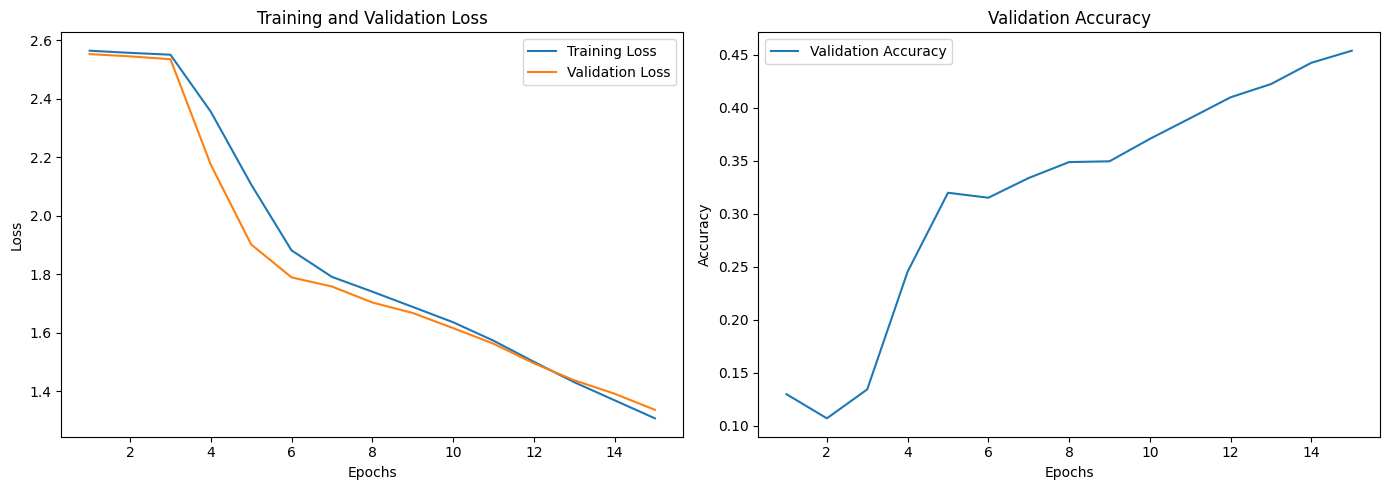


Evaluating on Test Set:
Accuracy: 0.4487
Recall: 0.5501

Precision: 0.5501
              precision    recall  f1-score   support

     sadness       0.99      1.00      0.99       300
     neutral       0.96      1.00      0.98       300
       worry       0.55      0.84      0.67       300
        love       0.47      0.91      0.62       300
   happiness       0.25      0.52      0.34       300
       anger       0.35      0.20      0.25       521
     boredom       0.46      0.87      0.60       300
       empty       0.40      0.47      0.43       384
  enthusiasm       0.44      0.16      0.23       864
         fun       0.32      0.55      0.40       300
        hate       0.31      0.24      0.27       517
      relief       0.21      0.19      0.20       300
    surprise       0.42      0.20      0.27       846

    accuracy                           0.45      5532
   macro avg       0.47      0.55      0.48      5532
weighted avg       0.45      0.45      0.42      5532



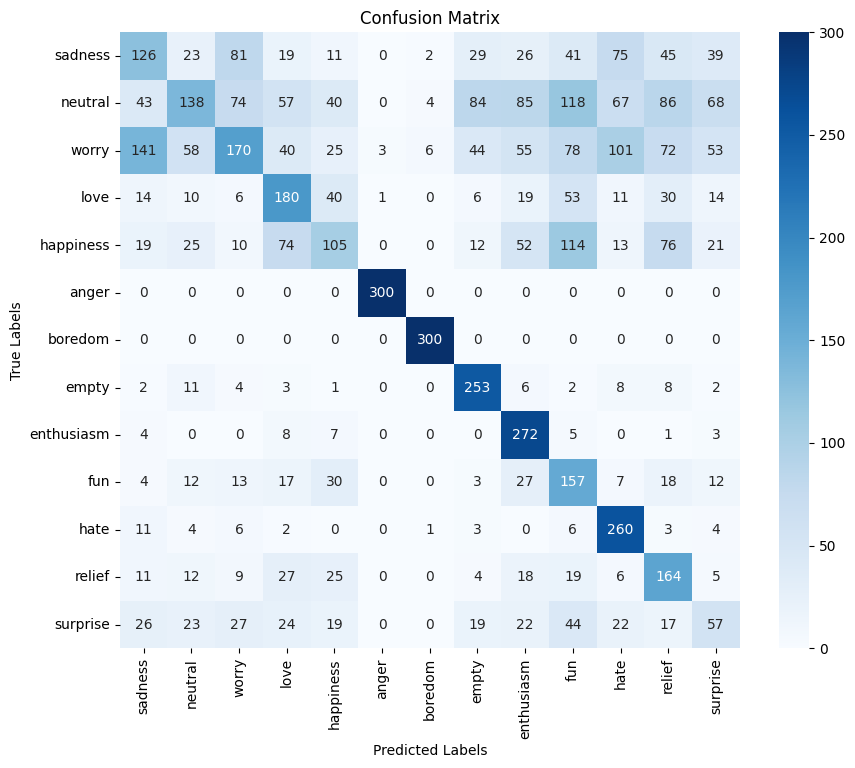

In [ ]:
# Define approach_1_data
approach_1_data = (train_loader1, val_loader1, test_loader1)

print("Training Approach 1 (Imbalanced):")
trained_model_1 = train_and_evaluate(approach_1_data, use_class_weights=True, label_mapping=label_mapping1)

#Confusion Matrix


Training Approach 2 (Balanced Data):


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Epoch 1/15


  Training Loss: 2.5554
  Validation Loss: 2.5352
  Validation Accuracy: 0.1087

Epoch 2/15


  Training Loss: 2.5415
  Validation Loss: 2.5175
  Validation Accuracy: 0.1305

Epoch 3/15


  Training Loss: 2.5287
  Validation Loss: 2.5050
  Validation Accuracy: 0.1231

Epoch 4/15
Unfreezing the last 4 BERT layers...


  Training Loss: 2.2430
  Validation Loss: 2.0446
  Validation Accuracy: 0.3008

Epoch 5/15


  Training Loss: 2.0190
  Validation Loss: 1.9080
  Validation Accuracy: 0.3636

Epoch 6/15


  Training Loss: 1.9008
  Validation Loss: 1.8642
  Validation Accuracy: 0.3823

Epoch 7/15


  Training Loss: 1.8232
  Validation Loss: 1.7950
  Validation Accuracy: 0.4031

Epoch 8/15


  Training Loss: 1.7571
  Validation Loss: 1.7699
  Validation Accuracy: 0.4123

Epoch 9/15


  Training Loss: 1.6955
  Validation Loss: 1.7316
  Validation Accuracy: 0.4310

Epoch 10/15


  Training Loss: 1.6406
  Validation Loss: 1.7000
  Validation Accuracy: 0.4390

Epoch 11/15


  Training Loss: 1.5879
  Validation Loss: 1.6795
  Validation Accuracy: 0.4533

Epoch 12/15


  Training Loss: 1.5338
  Validation Loss: 1.6580
  Validation Accuracy: 0.4562

Epoch 13/15


  Training Loss: 1.4902
  Validation Loss: 1.6387
  Validation Accuracy: 0.4669

Epoch 14/15


  Training Loss: 1.4400
  Validation Loss: 1.6460
  Validation Accuracy: 0.4751

Epoch 15/15


  Training Loss: 1.3984
  Validation Loss: 1.6230
  Validation Accuracy: 0.4764


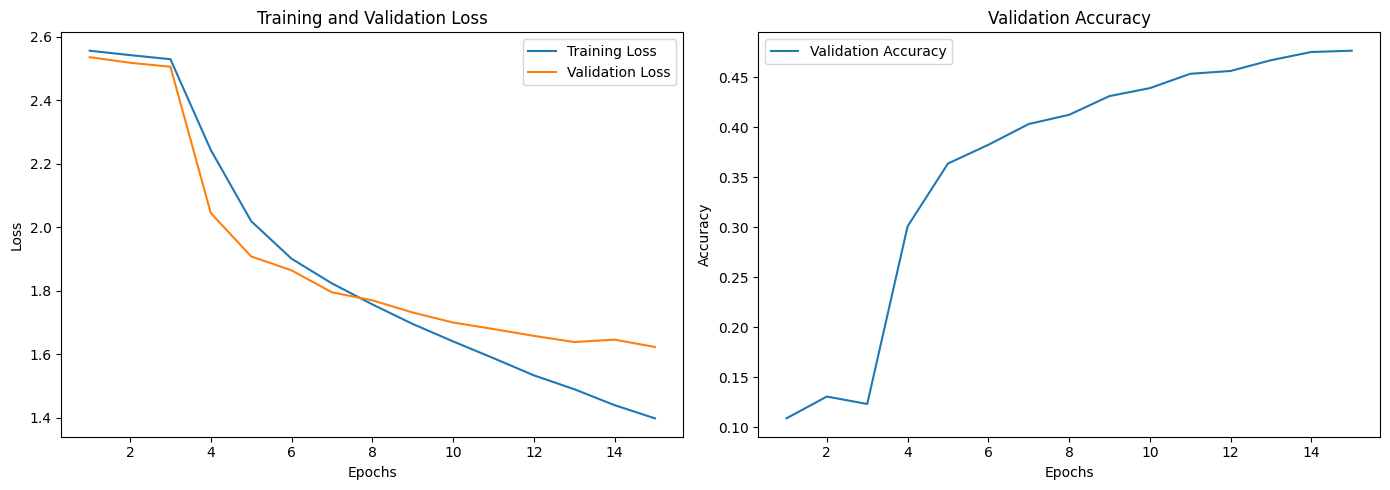


Evaluating on Test Set:
Accuracy: 0.4921
Recall: 0.4921

Precision: 0.4921
              precision    recall  f1-score   support

       anger       0.87      0.82      0.85       300
     boredom       0.80      0.86      0.83       300
       empty       0.80      0.68      0.73       300
  enthusiasm       0.56      0.62      0.59       300
         fun       0.34      0.41      0.37       300
   happiness       0.25      0.31      0.28       300
        hate       0.57      0.53      0.55       300
        love       0.42      0.52      0.46       300
     neutral       0.31      0.34      0.32       300
      relief       0.47      0.43      0.45       300
     sadness       0.32      0.33      0.33       300
    surprise       0.53      0.42      0.47       300
       worry       0.20      0.12      0.15       300

    accuracy                           0.49      3900
   macro avg       0.50      0.49      0.49      3900
weighted avg       0.50      0.49      0.49      3900



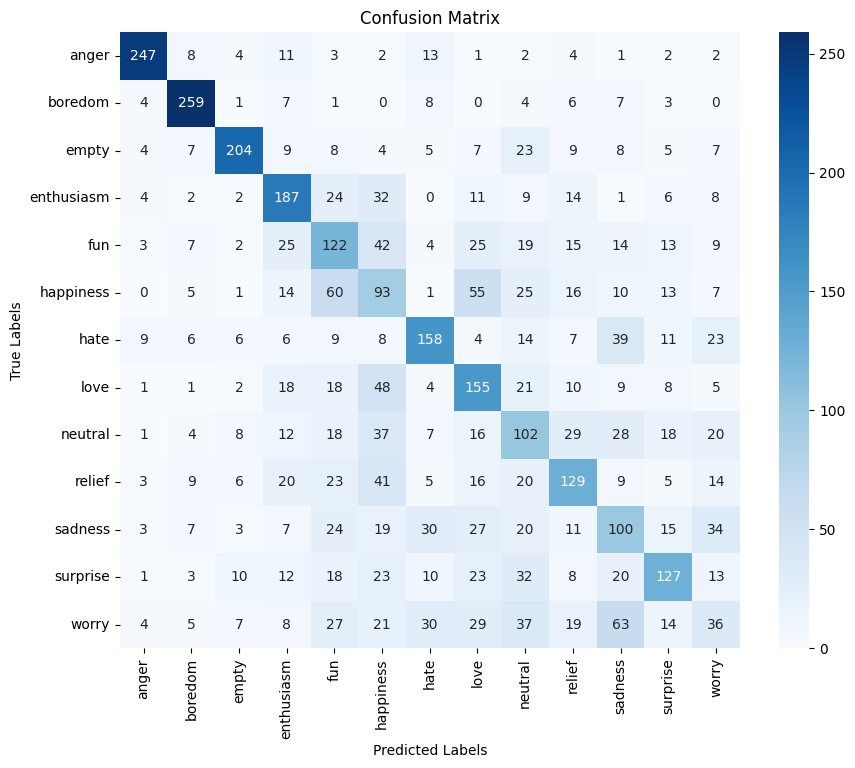

In [ ]:
# Define approach_2_data (Balanced Data)
approach_2_data = (train_loader2, val_loader2, test_loader2)

print("Training Approach 2 (Balanced Data):")
trained_model_2 = train_and_evaluate(approach_2_data, use_class_weights=False, label_mapping=label_mapping2)

Training Approach 3 (Slightly Imbalanced Data):


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/15


  Training Loss: 1.6189
  Validation Loss: 1.3851
  Validation Accuracy: 0.3149

Epoch 2/15


  Training Loss: 1.3906
  Validation Loss: 1.3653
  Validation Accuracy: 0.3666

Epoch 3/15


  Training Loss: 1.3743
  Validation Loss: 1.3564
  Validation Accuracy: 0.2898

Epoch 4/15
Unfreezing the last 4 BERT layers...


  Training Loss: 1.2509
  Validation Loss: 1.1988
  Validation Accuracy: 0.4205

Epoch 5/15


  Training Loss: 1.1774
  Validation Loss: 1.1837
  Validation Accuracy: 0.4762

Epoch 6/15


  Training Loss: 1.1563
  Validation Loss: 1.1707
  Validation Accuracy: 0.4576

Epoch 7/15


  Training Loss: 1.1297
  Validation Loss: 1.1730
  Validation Accuracy: 0.4583

Epoch 8/15


  Training Loss: 1.1088
  Validation Loss: 1.1671
  Validation Accuracy: 0.4674

Epoch 9/15


  Training Loss: 1.0935
  Validation Loss: 1.1833
  Validation Accuracy: 0.4598

Epoch 10/15


  Training Loss: 1.0675
  Validation Loss: 1.1860
  Validation Accuracy: 0.4569

Epoch 11/15


  Training Loss: 1.0503
  Validation Loss: 1.1902
  Validation Accuracy: 0.4645
Early stopping triggered. Restoring best model...


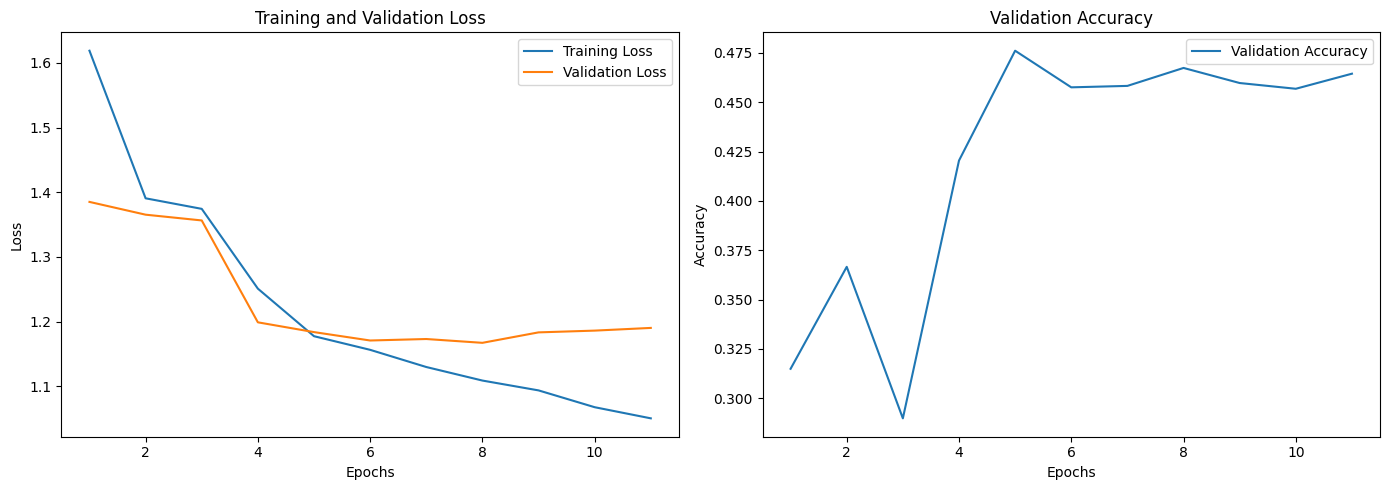


Evaluating on Test Set:
Accuracy: 0.4600
Recall: 0.4833

Precision: 0.4833
              precision    recall  f1-score   support

     sadness       0.46      0.64      0.54       521
     neutral       0.54      0.45      0.49       864
       worry       0.36      0.52      0.43       517
   happiness       0.48      0.33      0.39       846

    accuracy                           0.46      2748
   macro avg       0.46      0.48      0.46      2748
weighted avg       0.47      0.46      0.46      2748



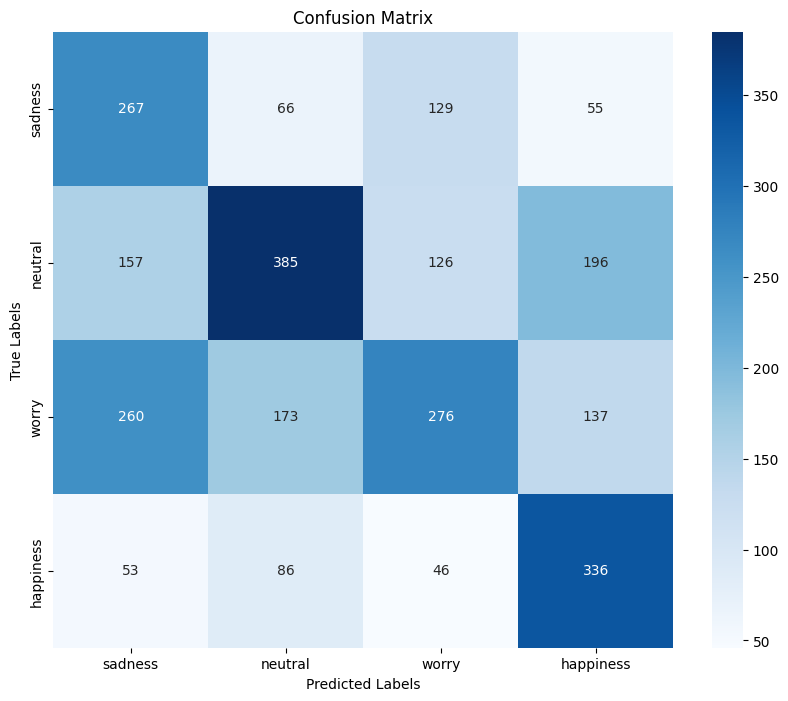

In [ ]:
# Define approach_3_data (Slightly Imbalanced Data)
approach_3_data = (train_loader3, val_loader3, test_loader3)

print("Training Approach 3 (Slightly Imbalanced Data):")
trained_model_3 = train_and_evaluate(approach_3_data, use_class_weights=True, label_mapping=label_mapping3)

# **Visualization (tSNE)**

In [ ]:
from sklearn.manifold import TSNE

def visualize_embeddings_tsne(model, dataloader, label_mapping, n_samples=1000):

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            label_batch = batch["labels"].cpu().numpy()

            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output.cpu().numpy()

            embeddings.append(pooled_output)
            labels.extend(label_batch)

            if len(labels) >= n_samples:
                break

    # Stack and trim embeddings
    embeddings = np.vstack(embeddings)[:n_samples]
    labels = labels[:n_samples]

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=40, random_state=42, n_iter=1000)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Reverse map labels
    reverse_map = {v: k for k, v in label_mapping.items()}
    label_names = [reverse_map[l] for l in labels]

    # Plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=label_names, palette="Set2", alpha=0.7)
    plt.title("t-SNE Visualization of BERT Pooled Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    # plt.show()
    plt.savefig("tsne.png")


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


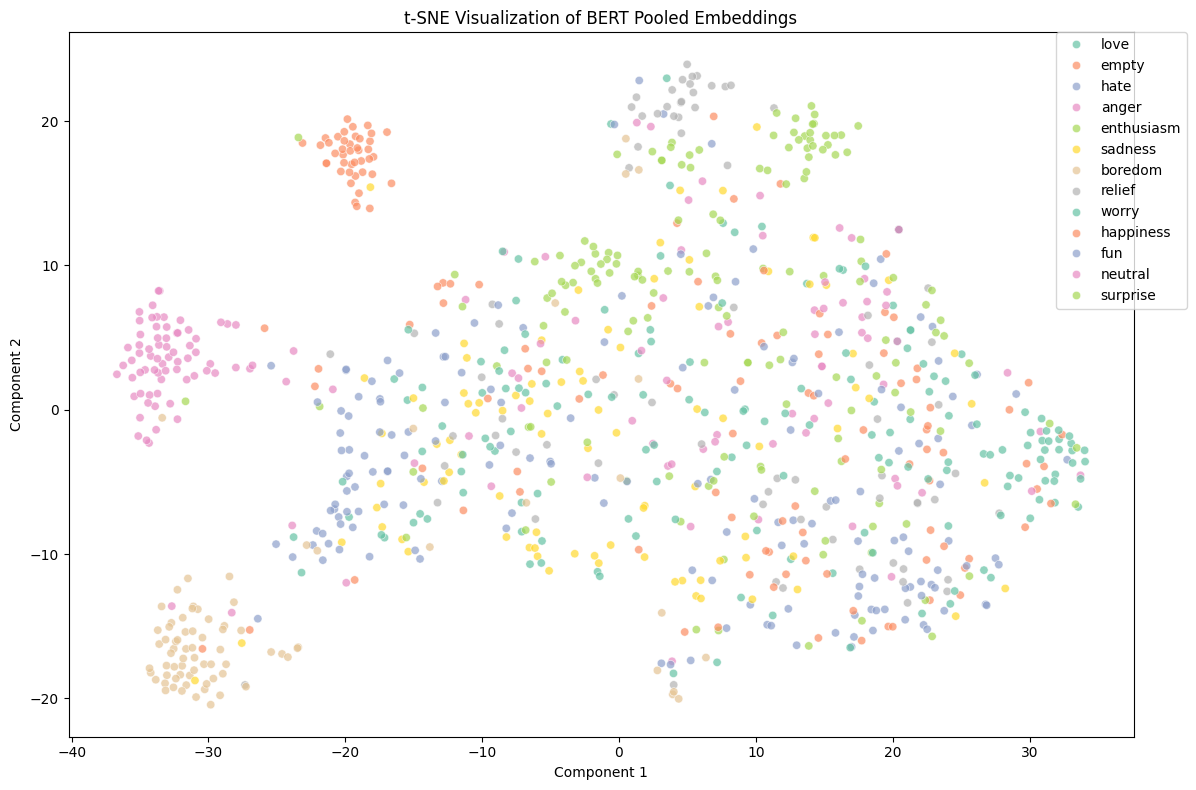

In [ ]:
#Visualize BERT Embeddings
# visualize_embeddings_tsne(trained_model_1, test_loader1, label_mapping1, n_samples=1000)
visualize_embeddings_tsne(trained_model_2, test_loader2, label_mapping2, n_samples=1000)

**Scatterplot with Regression Line**

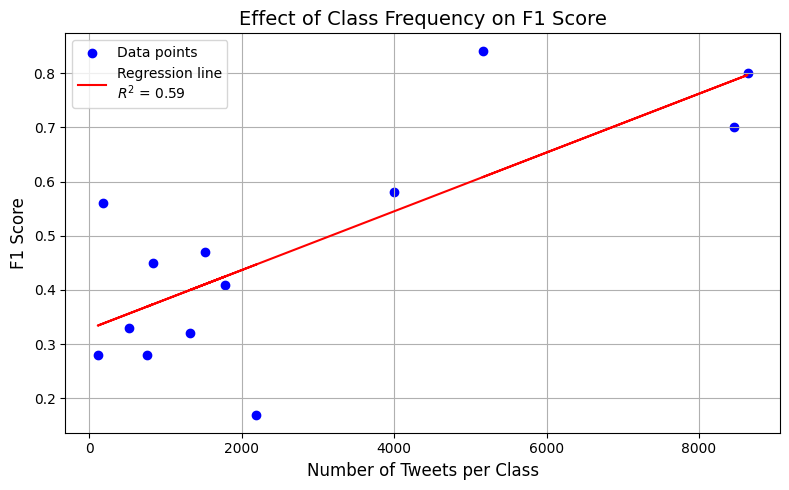

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Emotion class sample counts and corresponding F1 scores
counts = np.array([5165, 8638, 8459, 4000, 520, 110, 180, 830, 759, 1780, 1320, 1520, 2187])
f1_scores = np.array([0.84, 0.80, 0.70, 0.58, 0.33, 0.28, 0.56, 0.45, 0.28, 0.41, 0.32, 0.47, 0.17])

# Reshape data for linear regression
X = counts.reshape(-1, 1)
y = f1_scores

# Fit linear regression model
reg = LinearRegression().fit(X, y)
preds = reg.predict(X)
r2 = reg.score(X, y)

# Create plot
plt.figure(figsize=(8, 5))
plt.scatter(counts, f1_scores, color='blue', label='Data points')
plt.plot(counts, preds, color='red', label=f'Regression line\n$R^2$ = {r2:.2f}')
plt.xlabel("Number of Tweets per Class", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("Effect of Class Frequency on F1 Score", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("/mnt/data/regression_figure8.png")
plt.show()
